In [170]:
import sys
import pandas
import numpy as np
import imblearn
import sklearn
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score



from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# pandas.set_option('display.max_columns', None)
# pandas.set_option('display.max_rows', None)

### Read CSV

In [2]:
df = pandas.read_csv("ufcdata/data.csv").drop(columns = ["Referee", "R_fighter", "B_fighter", "location", "date"]).dropna().reset_index()
df = df.drop(columns = ["index"])
df.title_bout = df.title_bout.astype(int)

df["Winner"][df["Winner"] == "Red"] = 1
df["Winner"][df["Winner"] == "Blue"] = 0
# df["Winner"][df["Winner"] == "Draw"] = 3


df = df[df["Winner"] != "Draw"].reset_index(drop=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
df["Winner"].value_counts()

1    2023
0    1141
Name: Winner, dtype: int64

### EDA Work

In [4]:
# list(df.keys())
R_status = []
B_status = []
global_status = []
for i in list(df.keys()):
    if("R_" in i[:3]):
        R_status.append(i)
    elif("B_" in i):
        B_status.append(i)
    else:
        global_status.append(i)
B_status.remove("B_Stance")
R_status.remove("R_Stance")

len(R_status), len(B_status)

(67, 67)

In [5]:
len(global_status)
global_status

['Winner', 'title_bout', 'weight_class', 'no_of_rounds']

In [6]:
# R_ and B_ status
df1 = pandas.DataFrame()
for side in ["R_", "B_"]:
    keys = list(sorted(df[side+"Stance"].unique()))
    lis = list()
    for i in df[side+"Stance"].tolist():
        zero = np.zeros((1,len(keys)))
        zero[0][keys.index(i)] = 1
        lis.append(zero[0])
    _keys = []
    for i in keys:
        _keys.append(side+i)
    df_temp = pandas.DataFrame(lis, columns = _keys)
    
    for i in df_temp.keys():
        df1[i] = df_temp[i]
df1.tail()

,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch
3159,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3160,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3161,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3162,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3163,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Weight class feature
keys = list(sorted(df["weight_class"].unique()))
lis = list()
for i in df["weight_class"].tolist():
    zero = np.zeros((1,len(keys)))
    zero[0][keys.index(i)] = 1
    lis.append(zero[0])
_keys = []
for i in keys:
    _keys.append(i)
df2 = pandas.DataFrame(lis, columns = _keys).astype('float')
# df2.reset_index(drop=True)
df2.tail()

,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
3159,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3161,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3163,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Combine three df
temp_df = df

drop_list = ["R_Stance", "B_Stance", "weight_class"]
df = (pandas.concat([df, df1,df2], axis=1)).drop(columns = drop_list)
df = df.astype('float')
df


,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
0,1.0,1.0,5.0,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,5.0,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,3.0,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.0,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,3.0,0.0,3.0,0.0,15.000000,7.416667,6.083333,3.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,3.0,1.0,0.0,0.0,16.250000,11.000000,17.500000,11.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,3.0,0.0,1.0,0.0,7.250000,4.750000,1.750000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,3.0,0.0,1.0,0.0,25.400000,17.900000,22.500000,16.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,3.0,1.0,0.0,0.0,5.428571,4.142857,12.285714,9.142857,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# The differeance between two fighter
new_key = []
for i in B_status:
    new_key.append(i.replace("B_", "Difference"))
new_key

df3 = pandas.DataFrame(df[B_status].to_numpy() - df[R_status].to_numpy(), columns = new_key)
df3.tail()


,Differencecurrent_lose_streak,Differencecurrent_win_streak,Differencedraw,Differenceavg_BODY_att,Differenceavg_BODY_landed,Differenceavg_CLINCH_att,Differenceavg_CLINCH_landed,Differenceavg_DISTANCE_att,Differenceavg_DISTANCE_landed,Differenceavg_GROUND_att,...,Differencewin_by_Decision_Split,Differencewin_by_Decision_Unanimous,Differencewin_by_KO/TKO,Differencewin_by_Submission,Differencewin_by_TKO_Doctor_Stoppage,Differencewins,DifferenceHeight_cms,DifferenceReach_cms,DifferenceWeight_lbs,Differenceage
3159,0.0,1.0,0.0,5.523810,5.238095,5.714286,5.714286,-1.619048,2.285714,-10.619048,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3160,0.0,0.0,0.0,8.333333,8.000000,-10.666667,-6.333333,-22.000000,-8.666667,44.666667,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3161,-1.0,1.0,0.0,4.400000,4.900000,8.700000,10.200000,-11.600000,-2.900000,-27.100000,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3162,-2.0,1.0,0.0,6.500000,4.000000,33.500000,19.500000,45.500000,18.000000,4.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3163,0.0,1.0,0.0,0.166667,0.166667,8.666667,4.000000,2.666667,1.666667,0.333333,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [10]:
# Combine df as well
df = pandas.concat([df, df3], axis=1)
df.tail()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Differencewin_by_Decision_Split,Differencewin_by_Decision_Unanimous,Differencewin_by_KO/TKO,Differencewin_by_Submission,Differencewin_by_TKO_Doctor_Stoppage,Differencewins,DifferenceHeight_cms,DifferenceReach_cms,DifferenceWeight_lbs,Differenceage
3159,1.0,1.0,5.0,0.0,3.0,0.0,7.666667,6.666667,10.000000,7.0,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3160,1.0,0.0,3.0,0.0,1.0,0.0,12.000000,10.000000,6.000000,3.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3161,1.0,1.0,5.0,0.0,1.0,0.0,7.000000,6.500000,14.500000,12.0,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3162,1.0,0.0,2.0,0.0,1.0,0.0,9.000000,6.000000,36.000000,21.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3163,1.0,0.0,2.0,0.0,3.0,0.0,0.666667,0.666667,8.666667,4.0,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [12]:
Y = df["Winner"].tolist()

In [13]:
# scale them 
scale_df = df.drop(columns = ["Winner"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
df = scale_df


In [14]:
df["Winner"] = Y

### Sampling the dataset

In [ ]:
X = df.drop(columns = ["Winner"])

rus = imblearn.over_sampling.SMOTE(ratio={3:100 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))


In [ ]:
# over_sampling.
X = df
rus = imblearn.over_sampling.ADASYN(ratio={3:1000 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))

In [ ]:
sampled_df = pandas.DataFrame(X_rus, columns = df.keys())
sampled_df["Winner"] = Y_rus
df = sampled_df

In [ ]:
# Before Sampling

Y = df["Winner"]
PCA_df = df.drop(columns = ["Winner"])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,3]
colors = ['r', 'g','b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

([<matplotlib.axis.XTick at 0x1a1adb0a20>,
 <a list of 12 Text xticklabel objects>)

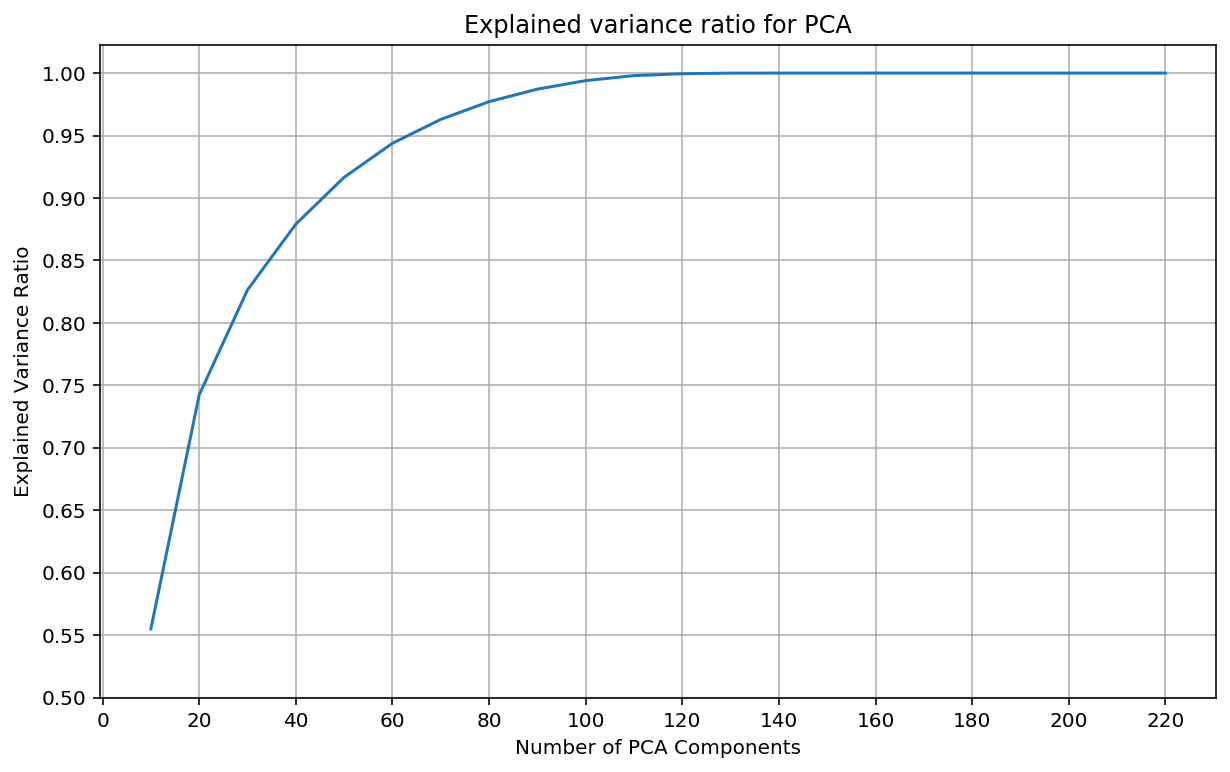

In [128]:
candidate_components = range(10, 225, 10)
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(df.drop(columns = ["Winner"]))
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5, 1.05, .05))
plt.xticks(np.arange(0, 240, 20))

### PCA reducation 

In [197]:
pca = PCA(n_components=120)
pca.fit(df.drop(columns = ["Winner"]))

PCA(copy=True, iterated_power='auto', n_components=120, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [198]:
PCA_X = pca.transform(df.drop(columns = ["Winner"]))
PCA_X.shape

(3164, 120)

### Dataset 

In [205]:
# dataset = shuffle(sampled_df)
dataset = shuffle(df)



Valid_dataset = dataset[:100]
Train_dataset = dataset[100:-100]
Test_dataset = dataset[-100:]

Train_X = Train_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Train_Y = Train_dataset["Winner"].to_numpy(dtype = int)


Valid_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Valid_Y = Valid_dataset["Winner"].to_numpy(dtype = int)


Test_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Test_Y = Valid_dataset["Winner"].to_numpy(dtype = int)

In [199]:
sampled_df = pandas.DataFrame(PCA_X)
sampled_df["Winner"] = Y
sampled_df
dataset = shuffle(sampled_df)



Valid_dataset = dataset[:100]
Train_dataset = dataset[100:-100]
Test_dataset = dataset[-100:]

Train_X = Train_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Train_Y = Train_dataset["Winner"].to_numpy(dtype = int)


Valid_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Valid_Y = Valid_dataset["Winner"].to_numpy(dtype = int)


Test_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Test_Y = Valid_dataset["Winner"].to_numpy(dtype = int)

# ML Models

### Ensembling learning method

In [31]:
# Bagging for the model and return the best selection via given datasets
rng = np.random.RandomState(1)

def Bagging(model, Train_X, Train_Y, Vail_X, Vail_Y):  
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    for i in range(1, 20):
        Bagging_Model = BaggingClassifier(base_estimator= model, n_estimators = i, bootstrap=True, warm_start=False) #
        Bagging_Model.fit(Train_X, Train_Y)
        curr_score = Bagging_Model.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest



In [32]:
# Adam boost for the model and return the best selection via given datasets
def Ada_Model(model, Train_X, Train_Y, Vail_X, Vail_Y):
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    for i in range(1, 20):
        AdaBoost_model = AdaBoostClassifier(base_estimator=model, n_estimators=i, random_state=rng)
        AdaBoost_model.fit(Train_X, Train_Y)
        curr_score = AdaBoost_model.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest



In [33]:
# GBDT(Gradient Boosting Decision Tree) for the model and return the best selection via given datasets


def GBDT(model, Train_X, Train_Y, Vail_X, Vail_Y):
    coeff = 0
    highest = 0
    _range = np.arange(0.01, 1, 0.05)
    for i in (_range):
        GBDT = GradientBoostingClassifier(init = model, learning_rate = i)
        GBDT.fit(Train_X, Train_Y)
        curr_score = GBDT.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest

### Neural Network 

In [272]:
# Best model for both recall and precision with 120 feature
NN = MLPClassifier(solver='sgd',  # weight optimization
                    activation='relu',  # activation function tanh
                    alpha=1, # Regularizer value
                    learning_rate_init = 0.00001,
#                     hidden_layer_sizes=(12,10,9), # layer and node (node,node) --> numbers of layers
                    hidden_layer_sizes=(64,32,16), # layer and node (node,node) --> numbers of layers


                  random_state=1, #random state
                    max_iter = 1000, # max iteration
                    early_stopping = True) # early stop

NN.fit(Train_X, Train_Y) # fit the neural network
NN.score(Train_X,Train_Y)

# sgd, adam, lbfgs
# 'identity', 'logistic', 'tanh', 'relu'

0.5067476383265856

In [273]:
print(sklearn.metrics.classification_report(Train_Y, NN.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.36      0.49      0.42      1060
           1       0.65      0.51      0.57      1904

    accuracy                           0.51      2964
   macro avg       0.50      0.50      0.49      2964
weighted avg       0.54      0.51      0.52      2964



In [240]:
NN.coefs_

[array([[-0.02384834,  0.06332933, -0.14362557, ..., -0.02470233,
          0.0560666 , -0.02467149],
        [-0.12934736,  0.0103221 ,  0.04717469, ...,  0.01116096,
          0.01588719,  0.09827812],
        [-0.10802207, -0.06346735,  0.02465823, ...,  0.1220998 ,
         -0.06787948, -0.12475595],
        ...,
        [ 0.12266962,  0.03488268,  0.06539512, ..., -0.09065534,
          0.02699194,  0.07276867],
        [-0.12093567,  0.08733879, -0.10415978, ..., -0.08749068,
          0.11118209, -0.12861201],
        [-0.14351445,  0.08774099, -0.00885407, ..., -0.12210542,
         -0.06674853, -0.04500632]]),
 array([[-0.22299574, -0.22241431,  0.00349613, ...,  0.00071503,
          0.05544274, -0.17409601],
        [ 0.19283237, -0.10518803,  0.19414646, ...,  0.21408538,
          0.11609102,  0.00502818],
        [-0.2161911 , -0.01340978,  0.03772427, ...,  0.04328625,
         -0.04762959, -0.07295206],
        ...,
        [-0.09245367, -0.17877297, -0.14867692, ...,  

In [241]:
NN.intercepts_

[array([-0.10747362, -0.01209798,  0.09692449,  0.14095181, -0.06783283,
        -0.06580637, -0.05327308, -0.08877211,  0.09813635,  0.06706431,
        -0.0477342 ,  0.12674558, -0.03728684,  0.06853892, -0.10668901,
        -0.00718852,  0.06072981,  0.00369799,  0.01395809,  0.02435488,
         0.05786447,  0.04059385, -0.03233095, -0.10674665, -0.10064951,
         0.04379066,  0.11720246, -0.05106436, -0.13307698, -0.13754117,
         0.0448228 ,  0.13427043,  0.14267149,  0.12266089,  0.04394712,
         0.08056202, -0.03200525,  0.12496068,  0.07302851,  0.1388704 ,
        -0.02942012, -0.0371536 ,  0.12204983, -0.07042334,  0.11425723,
        -0.13745769, -0.11219151,  0.01322386, -0.01951813,  0.03760249,
        -0.05465152,  0.06026053, -0.02054423,  0.01165689,  0.00089477,
        -0.13073871,  0.04003842,  0.06341545,  0.06087174, -0.02059935,
         0.11849475, -0.0126998 ,  0.0477577 , -0.13005503]),
 array([-0.17358597, -0.16262622, -0.22582653,  0.24609652,  0

In [274]:
NN.score(Test_X,Test_Y)

0.5

In [275]:
print(sklearn.metrics.classification_report(Test_Y, NN.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.43      0.57      0.49        42
           1       0.59      0.45      0.51        58

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.52      0.50      0.50       100



In [104]:
coeff, highest = Bagging(NN, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

(11, 0.67)

In [105]:
Bagging_NN = BaggingClassifier(base_estimator=NN, n_estimators=coeff, random_state=rng)
Bagging_NN.fit(Train_X, Train_Y)
Bagging_NN.score(Train_X,Train_Y)

0.6400134952766532

In [106]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_NN.predict(Train_X)) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1065
           1       0.64      1.00      0.78      1899

    accuracy                           0.64      2964
   macro avg       0.32      0.50      0.39      2964
weighted avg       0.41      0.64      0.50      2964



In [107]:
Bagging_NN.score(Test_X,Test_Y)

0.66

In [108]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_NN.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.66      1.00      0.80        66

    accuracy                           0.66       100
   macro avg       0.33      0.50      0.40       100
weighted avg       0.44      0.66      0.52       100



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
coeff, highest = GBDT(Bagging_NN, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
GBDT_NN = GradientBoostingClassifier(init=Bagging_NN, learning_rate = coeff)
GBDT_NN.fit(Train_X, Train_Y)
GBDT_NN.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_NN.predict(Train_X)) )

In [ ]:
GBDT_NN.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_NN.predict(Test_X)) )

In [ ]:
target_0 = df.loc[df['Winner'] == 0]
target_1 = df.loc[df['Winner'] == 1]
target_2 = df.loc[df['Winner'] == 3]

sns.distplot(target_0[['no_of_rounds']], hist=False, rug=True, color = "red")
sns.distplot(target_1[['no_of_rounds']], hist=False, rug=True, color = "blue")
sns.distplot(target_2[['no_of_rounds']], hist=False, rug=True, color = "green")

plt.show()

In [ ]:
df1 = pandas.DataFrame()

for side in ["R_", "B_"]:
    temp = list(sorted(df[side+"Stance"].unique()))
    
    lis = []
    for i in temp:
#         lis.append(key +" - "+i)
        lis.append(side+"Stance_"+i)
    lis = sorted(lis)
    row = np.zeros(len(lis))
    print(lis)

    onehot_df = pandas.DataFrame(columns = lis)
    row, lis
    for i in df[side+"Stance"].tolist():
        row = np.zeros(len(lis))
        index = temp.index(i)
        row[index] = 1
        row = np.reshape(row, (1, len(lis)))
        df2 = pandas.DataFrame(data = row, columns = lis)
        onehot_df = onehot_df.append(df2, ignore_index = True) 
        
    for i in onehot_df.keys():
        df1[i] = onehot_df[i].tolist()
df1.tail()